<a href="https://colab.research.google.com/github/VaishU2235/MobileNet-transfer-learning/blob/master/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip intel-image-classification.zip

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [9]:
import numpy as np
import pandas as pd

In [10]:
import pathlib

In [11]:
data_dir_train=pathlib.Path('seg_train/seg_train')

In [12]:
data_dir_test=pathlib.Path('seg_test/seg_test')

In [13]:
batch_size = 32
img_height = 150
img_width = 150

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 6 classes.


In [16]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


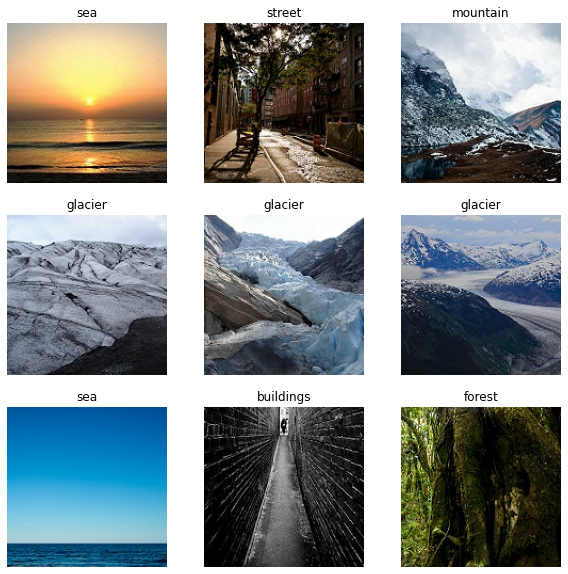

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [22]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [24]:
history = model.fit(
  train_ds,
  validation_data=val_ds,epochs=5,
  callbacks=[callback])

Epoch 1/5
439/439 [==============================] - 21s 43ms/step - loss: 1.0172 - accuracy: 0.6050 - val_loss: 0.7829 - val_accuracy: 0.6923
Epoch 2/5
439/439 [==============================] - 14s 33ms/step - loss: 0.6768 - accuracy: 0.7543 - val_loss: 0.6565 - val_accuracy: 0.7647
Epoch 3/5
439/439 [==============================] - 14s 33ms/step - loss: 0.5614 - accuracy: 0.7964 - val_loss: 0.6541 - val_accuracy: 0.7643
Epoch 4/5
439/439 [==============================] - 14s 33ms/step - loss: 0.4603 - accuracy: 0.8350 - val_loss: 0.6392 - val_accuracy: 0.7840
Epoch 5/5
439/439 [==============================] - 14s 33ms/step - loss: 0.3661 - accuracy: 0.8680 - val_loss: 0.8428 - val_accuracy: 0.7483


In [27]:
model.save(filepath='simple')

INFO:tensorflow:Assets written to: simple/assets


## Pre-trained Weights

In [28]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [29]:
pre_trained_model = InceptionV3(input_shape = (img_height, img_width, 3),
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [30]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [31]:
#for layer in pre_trained_model.layers:
#  rand=np.random.uniform(0,1,1)
#  if rand<0.8: #A clever way to make 20% of orginal layers trainable
#    layer.trainable = False

In [33]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(num_classes)(x)           

new_model = tf.keras.Model(pre_trained_model.input, x) 

new_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [34]:
history = new_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = 5)

Epoch 1/5
439/439 [==============================] - 55s 111ms/step - loss: 39.8602 - accuracy: 0.3346 - val_loss: 1.5979 - val_accuracy: 0.3053
Epoch 2/5
439/439 [==============================] - 46s 104ms/step - loss: 1.5398 - accuracy: 0.3403 - val_loss: 1.6218 - val_accuracy: 0.2777
Epoch 3/5
439/439 [==============================] - 46s 104ms/step - loss: 1.5221 - accuracy: 0.3271 - val_loss: 1.5549 - val_accuracy: 0.3270
Epoch 4/5
439/439 [==============================] - 46s 104ms/step - loss: 1.4926 - accuracy: 0.3498 - val_loss: 1.5900 - val_accuracy: 0.3003
Epoch 5/5
439/439 [==============================] - 46s 104ms/step - loss: 1.4533 - accuracy: 0.3623 - val_loss: 1.4937 - val_accuracy: 0.3377


In [35]:
new_model.save(filepath='pretrained')

INFO:tensorflow:Assets written to: pretrained/assets


In [37]:
!zip -r /content/simple.zip /content/simple

from google.colab import files
files.download("/content/simple.zip")

  adding: content/simple/ (stored 0%)
  adding: content/simple/assets/ (stored 0%)
  adding: content/simple/variables/ (stored 0%)
  adding: content/simple/variables/variables.data-00000-of-00001 (deflated 25%)
  adding: content/simple/variables/variables.index (deflated 67%)
  adding: content/simple/.ipynb_checkpoints/ (stored 0%)
  adding: content/simple/keras_metadata.pb (deflated 91%)
  adding: content/simple/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
!zip -r /content/pretrained.zip /content/pretrained

from google.colab import files
files.download("/content/pretrained.zip")

  adding: content/pretrained/ (stored 0%)
  adding: content/pretrained/assets/ (stored 0%)
  adding: content/pretrained/variables/ (stored 0%)
  adding: content/pretrained/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/pretrained/variables/variables.index (deflated 79%)
  adding: content/pretrained/keras_metadata.pb (deflated 96%)
  adding: content/pretrained/saved_model.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>